Example 6.5: Windy Gridworld

Sutton Book

method: sarsa
====trajectory of the latest episode====
*	*	*	*	*	*	→	→	→	↓	
*	*	*	*	*	→	*	*	*	↓	
*	*	*	*	→	*	*	*	*	↓	
→	→	→	→	*	*	*	G	*	↓	
*	*	*	*	*	*	*	*	←	←	
*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	
0	0	0	1	1	1	2	2	1	0	

====optimal policy====
→	↑	→	→	→	→	→	→	→	↓	
→	→	→	↓	→	→	→	→	↑	↓	
↑	→	→	→	→	→	→	→	→	↓	
→	→	→	→	→	→	→	G	→	↓	
→	→	↓	→	→	→	↑	↓	←	←	
→	↓	→	→	→	↑	↑	↓	↓	↓	
→	→	→	→	↑	↑	↑	↑	↑	←	
0	0	0	1	1	1	2	2	1	0	

method: q-learning
====trajectory of the latest episode====
*	*	*	*	*	*	→	→	→	↓	
*	*	*	*	*	→	*	*	*	↓	
*	*	*	*	→	*	*	*	*	↓	
→	→	→	→	*	*	*	G	*	↓	
*	*	*	*	*	*	*	*	←	←	
*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	
0	0	0	1	1	1	2	2	1	0	

====optimal policy====
→	↑	→	→	→	→	→	→	→	↓	
←	→	→	→	→	→	→	→	→	↓	
→	→	→	→	→	→	→	→	→	↓	
→	→	→	→	→	→	→	G	→	↓	
→	→	→	→	↓	→	↑	↓	←	←	
←	→	↑	→	→	↑	↑	←	←	←	
↓	→	→	→	↑	↑	↑	↑	←	↓	
0	0	0	1	1	1	2	2	1	0	



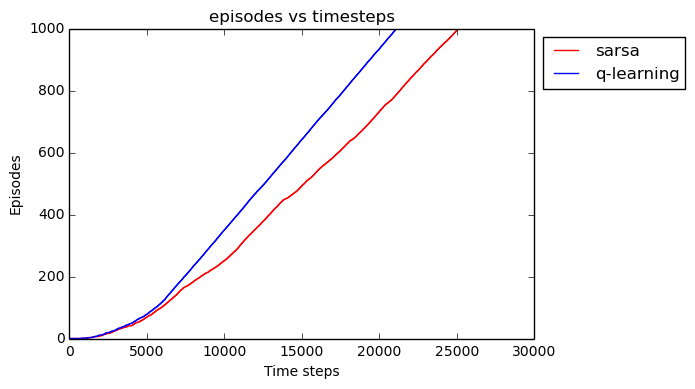

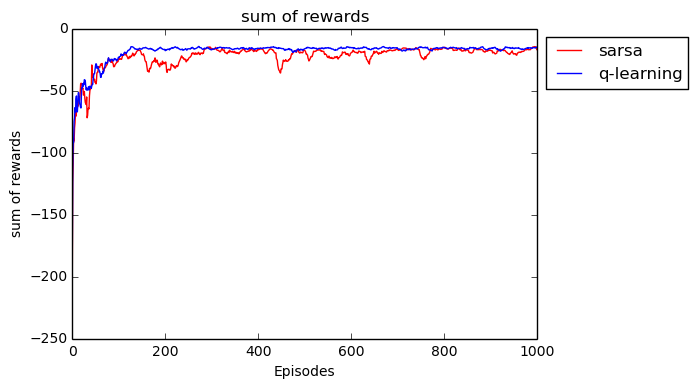

In [36]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

''' the world '''
WORLD_WIDTH = 10
WORLD_HEIGHT = 7
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] # south wind

''' rules '''
START_STATE = (0, 3)
GOAL_STATE = (7, 3)

''' actions '''
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

''' policy '''
EPSILON = 0.1
ALPHA = 0.5
GAMMA = 1

next_state_lookup_table = dict()
def get_next_state(state, action):
    ''' look up the next state given current state and action '''
    if state not in next_state_lookup_table:
        next_state_lookup_table[state] = dict()
        
    if action not in next_state_lookup_table[state]:
        x, y = state
        if action == ACTION_UP:
            next_state_lookup_table[state][action] = (x, min(y+1+WIND[x], WORLD_HEIGHT-1))
        if action == ACTION_DOWN:
            next_state_lookup_table[state][action] = (x, min(max(y-1+WIND[x], 0), WORLD_HEIGHT-1))
        if action == ACTION_LEFT:
            next_state_lookup_table[state][action] = (max(x-1, 0), min(y+WIND[x], WORLD_HEIGHT-1))
        if action == ACTION_RIGHT:
            next_state_lookup_table[state][action] = (min(x+1, WORLD_WIDTH-1), min(y+WIND[x], WORLD_HEIGHT-1))
    
    return next_state_lookup_table[state][action]


def one_episode_sarsa(Q):
    timesteps = 0
    trajectory = {}
    sum_of_rewards = 0
    
    # init state
    state = START_STATE
    
    # choose an action using policy derived from Q (ϵ-greedy)
    if np.random.rand() < EPSILON:
        action = np.random.choice(ACTIONS)
    else:
        action = np.argmax(Q[state[0], state[1], :])
        
    while state != GOAL_STATE:
        # take action, and observer next_state, reward
        next_state = get_next_state(state, action)
        if next_state != GOAL_STATE:
            reward = -1
        else:
            reward = 0
        sum_of_rewards += reward
        
        
        # choose the next action using policy derived from Q (ϵ-greedy)
        if np.random.rand() < EPSILON:
            next_action = np.random.choice(ACTIONS)
        else:
            next_action = np.argmax(Q[next_state[0], next_state[1], :]) 
        
        # update Q
        Q[state[0], state[1], action] += ALPHA * \
            (reward + GAMMA * Q[next_state[0], next_state[1], next_action] - Q[state[0], state[1], action])
        timesteps += 1
        
        trajectory[state] = action
        state = next_state
        action = next_action
        
    
    return timesteps, trajectory, sum_of_rewards


def one_episode_q_learning(Q):
    timesteps = 0
    trajectory = {}
    sum_of_rewards = 0
    
    # init state
    state = START_STATE
      
    while state != GOAL_STATE:
        # choose an action using policy derived from Q (ϵ-greedy)
        if np.random.rand() < EPSILON:
            action = np.random.choice(ACTIONS)
        else:
            action = np.argmax(Q[state[0], state[1], :])
        
        # take action, and observer next_state, reward
        next_state = get_next_state(state, action)
        if next_state != GOAL_STATE:
            reward = -1
        else:
            reward = 0
        sum_of_rewards += reward
        
        # update Q
        Q[state[0], state[1], action] += ALPHA * \
            (reward + GAMMA * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])
        timesteps += 1
            
        trajectory[state] = action
        state = next_state
    
    return timesteps, trajectory, sum_of_rewards


def print_trajectory(trajectory):
    table = []
    for y in range(WORLD_HEIGHT-1, -1, -1):
        table.append([])
        for x in range(0, WORLD_WIDTH):
            state = (x, y)
            if state == GOAL_STATE:
                table[-1].append('G')
                continue
            
            if state in trajectory:
                action = trajectory[state]
                if action == ACTION_UP:
                    table[-1].append('↑')
                elif action == ACTION_DOWN:
                    table[-1].append('↓')
                elif action == ACTION_LEFT:
                    table[-1].append('←')
                elif action == ACTION_RIGHT:
                    table[-1].append('→')
            else:
                table[-1].append('*')
                
    for row in table:
        for ch in row:
            print(ch, end="\t")
        print()
    
    for ch in WIND:
        print(ch, end="\t")
    print()


def test(method='sarsa'):
    # reset Q
    Q = np.zeros((WORLD_WIDTH, WORLD_HEIGHT, 4)) # state-action pair values
    
    n_episode = 1000
    ep = 0
    episodes = []
    sums_of_rewards = []
    while ep < n_episode:
        if method == 'sarsa':
            time, trajectory, sum_of_rewards = one_episode_sarsa(Q)
        elif method == 'q-learning':
            time, trajectory, sum_of_rewards = one_episode_q_learning(Q)
        episodes.extend([ep] * time)
        sums_of_rewards.append(sum_of_rewards)
        ep += 1
    
    print('method: %s' % method)
    print('====trajectory of the latest episode====')
    print_trajectory(trajectory)
    print()
    
    # print the optimal policy
    print('====optimal policy====') 
    optimal_policy = dict()
    for y in range(WORLD_HEIGHT-1, -1, -1):
        for x in range(0, WORLD_WIDTH):
            state = (x, y)
            if state != GOAL_STATE:
                best_action = np.argmax(Q[x, y, :])
                optimal_policy[state] = best_action
    print_trajectory(optimal_policy)
    print()
    
    return episodes, sums_of_rewards


episodes_sarsa, sums_of_rewards_sarsa = test(method='sarsa')  
episodes_q_learning, sums_of_rewards_q_learning = test(method='q-learning')

plt.figure()
plt.plot(range(len(episodes_sarsa)), episodes_sarsa, label='sarsa', color='red')
plt.plot(range(len(episodes_q_learning)), episodes_q_learning, label='q-learning', color='blue')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('episodes vs timesteps')
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()


sums_of_rewards_sarsa = sums_of_rewards_sarsa
sums_of_rewards_q_learning = sums_of_rewards_q_learning

smoothed_sums_sarsa = []
for i in xrange(len(sums_of_rewards_sarsa)):
    smoothed_sums_sarsa.append(np.average(sums_of_rewards_sarsa[i:i+10]))

smoothed_sums_q_learning = []
for i in xrange(len(sums_of_rewards_q_learning)):
    smoothed_sums_q_learning.append(np.average(sums_of_rewards_q_learning[i:i+10]))
    
plt.figure()
plt.plot(range(len(smoothed_sums_sarsa)), smoothed_sums_sarsa, label='sarsa', color='red')
plt.plot(range(len(smoothed_sums_q_learning)), smoothed_sums_q_learning, label='q-learning', color='blue')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('sum of rewards')
plt.xlabel('Episodes')
plt.ylabel('sum of rewards')
plt.show()